## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d

## Sklearn KMeans

In [2]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=6, n_features=2, random_state=67)

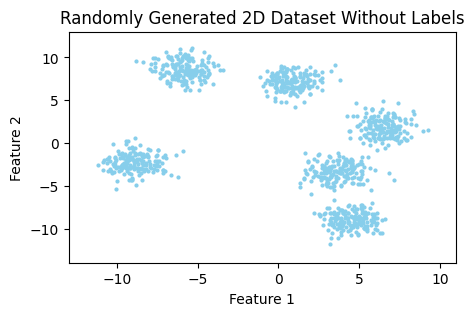

In [3]:
plt.figure(figsize=(5,3)) 
plt.scatter(X[:, 0], X[:, 1], 4, marker='o', c='skyblue')
plt.title("Randomly Generated 2D Dataset Without Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.show()

In [4]:
kmeans = KMeans(n_clusters=6, random_state=67)
km_labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

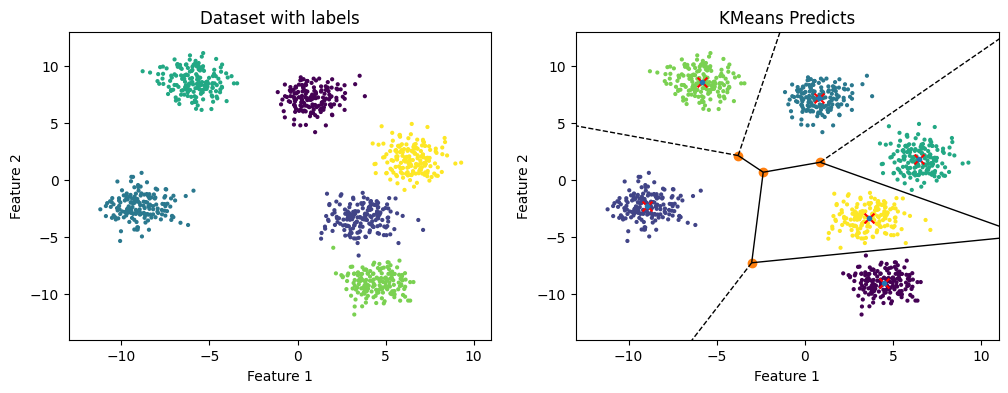

In [5]:
plt.figure(figsize=(12,4)) 
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], 4, c=y)
plt.title("Dataset with labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
vor = Voronoi(centers)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.title("KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=km_labels) 
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50)
plt.show()

## My KMeans

### Functions

In [6]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): k centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    ### START CODE HERE ###
    for sample in range(len(X)):
        distance = []
        for centroid in range(len(centroids)):
            norm = np.linalg.norm(X[sample] - centroids[centroid])
            distance.append(norm)
            
        idx[sample] = distance.index(min(distance))
    ### END CODE HERE ###
    
    return idx

In [7]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    ### START CODE HERE ###
    for k in range(K):   
              points = X[idx == k]
              centroids[k] = np.mean(points, axis=0)
    ### END CODE HERE ## 
    
    return centroids

In [8]:
def kmeans_on_steroids(X, n_clusters):
    centroids = [X[0]]

    for _ in range(1, n_clusters):
        squared_distances = np.array([min([np.inner(centroid - sample,centroid - sample) for centroid in centroids]) for sample in X])
        proba = squared_distances / squared_distances.sum()
        cumulative_proba = proba.cumsum()
        r = np.random.rand()
        
        for point, probability in enumerate(cumulative_proba):
            if r < probability:
                centroid = point
                break
        
        centroids.append(X[centroid])

    return np.array(centroids)

In [9]:
def kmeans(X, n_clusters, iters = 50):
    m, n = X.shape
    initial_centroids = kmeans_on_steroids(X, n_clusters)
    K = initial_centroids.shape[0]
    centroids = initial_centroids   
    labels = np.zeros(m)
    
    # Run K-Means
    for i in range(iters):
        
        #Output progress
        print(f"K-Means iteration {i}/{iters-1}")
        
        # For each example in X, assign it to the closest centroid
        labels = find_closest_centroids(X, centroids)
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, labels, K)
        
    return centroids, labels

### Implementation

In [14]:
centroids, labels = kmeans(X, 6)

K-Means iteration 0/49
K-Means iteration 1/49
K-Means iteration 2/49
K-Means iteration 3/49
K-Means iteration 4/49
K-Means iteration 5/49
K-Means iteration 6/49
K-Means iteration 7/49
K-Means iteration 8/49
K-Means iteration 9/49
K-Means iteration 10/49
K-Means iteration 11/49
K-Means iteration 12/49
K-Means iteration 13/49
K-Means iteration 14/49
K-Means iteration 15/49
K-Means iteration 16/49
K-Means iteration 17/49
K-Means iteration 18/49
K-Means iteration 19/49
K-Means iteration 20/49
K-Means iteration 21/49
K-Means iteration 22/49
K-Means iteration 23/49
K-Means iteration 24/49
K-Means iteration 25/49
K-Means iteration 26/49
K-Means iteration 27/49
K-Means iteration 28/49
K-Means iteration 29/49
K-Means iteration 30/49
K-Means iteration 31/49
K-Means iteration 32/49
K-Means iteration 33/49
K-Means iteration 34/49
K-Means iteration 35/49
K-Means iteration 36/49
K-Means iteration 37/49
K-Means iteration 38/49
K-Means iteration 39/49
K-Means iteration 40/49
K-Means iteration 41/49
K-

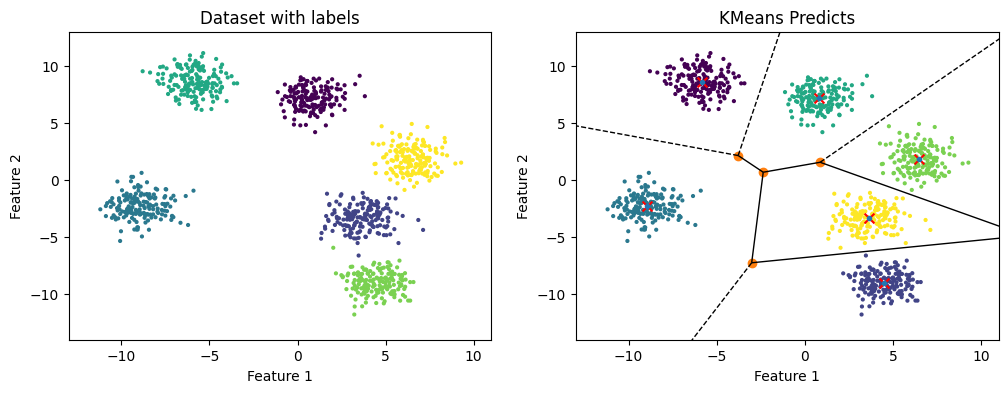

In [15]:
plt.figure(figsize=(12,4)) 
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], 4, c=y)
plt.title("Dataset with labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
vor = Voronoi(centroids)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.title("KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=labels) 
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50)
plt.show()

## Compare results

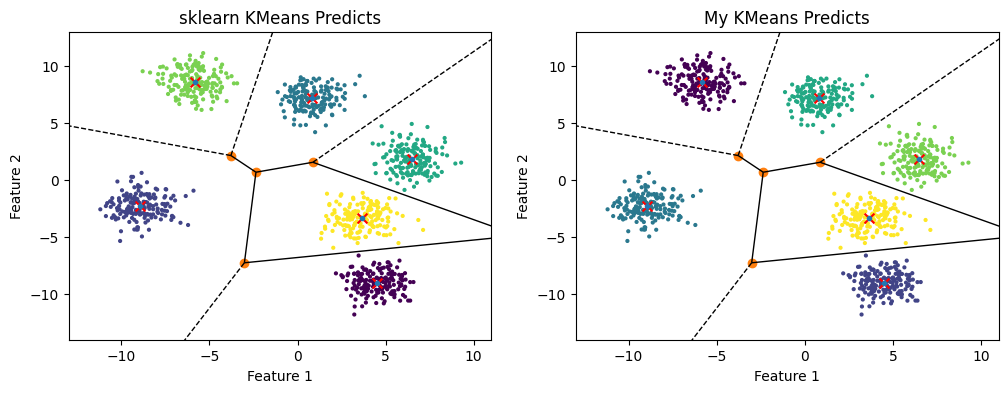

In [16]:
plt.figure(figsize=(12,4)) 
vor = Voronoi(centers)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 1))
plt.subplot(1, 2, 1)
plt.title("sklearn KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=km_labels) 
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50)
vor = Voronoi(centroids)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.subplot(1, 2, 2)
plt.title("My KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=labels) 
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50)
plt.show()